## DREaMing with Machines
In [an earlier notebook](https://github.com/broomgrass/Dream/blob/adding-files/MachineLearningTest.ipynb), I ran some initial document similarity tests on a corpus of texts that I had built from the DREaM corpus. In this notebook, using that refined corpus, I will try to run some machine learning experiments to see how well my corpus works.

First, let's recap a few of the cells from the past notebook. 

Here we are, loading in the corpus!

In [5]:
import nltk
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

data_dir = "C:/Users/broomgrass/iPython/Dream/data/texts"
corpus = PlaintextCorpusReader(data_dir+"/1600-1700corpus", ".*\.txt") 
# the modcorpus folder has the travel and nontravel texts together, with Other in the filename designating nontravel

Let's just quickly review what this corpus looks like, with a dendrogram and scatterplot.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram
%matplotlib inline

# plot the documents from the corpus
def plot_corpus_similarity(corpus, vectorizer):
    
    # generate the vector, distances and positions
    texts = [corpus.raw(fileid) for fileid in corpus.fileids()]
    documentTermMatrix = vectorizer.fit_transform(texts)
    distances = 1 - cosine_similarity(documentTermMatrix)
    mds = MDS(dissimilarity="precomputed", random_state=1)
    positions = mds.fit_transform(distances)
    
    # plot dendrogram
    linkage_matrix = ward(distances)
    plt.figure(figsize=(8,10))
    dendrogram(linkage_matrix, labels=corpus.fileids(), orientation="right");
    plt.show()  # fixes margins
    
    # plot scatter
    xvalues = positions[:, 0] 
    yvalues = positions[: ,1] 
    plt.figure(figsize=(20,10))
    for x, y, name in zip(xvalues, yvalues, corpus.fileids()):
        plt.scatter(x, y)
        # the colour-coding here is a bit of a hard-coded hack for what is otherwise mostly reusable code
        plt.text(x, y, name.replace(".txt", "")[:25], color='red' if 'Other' in name else 'green')
    plt.show()

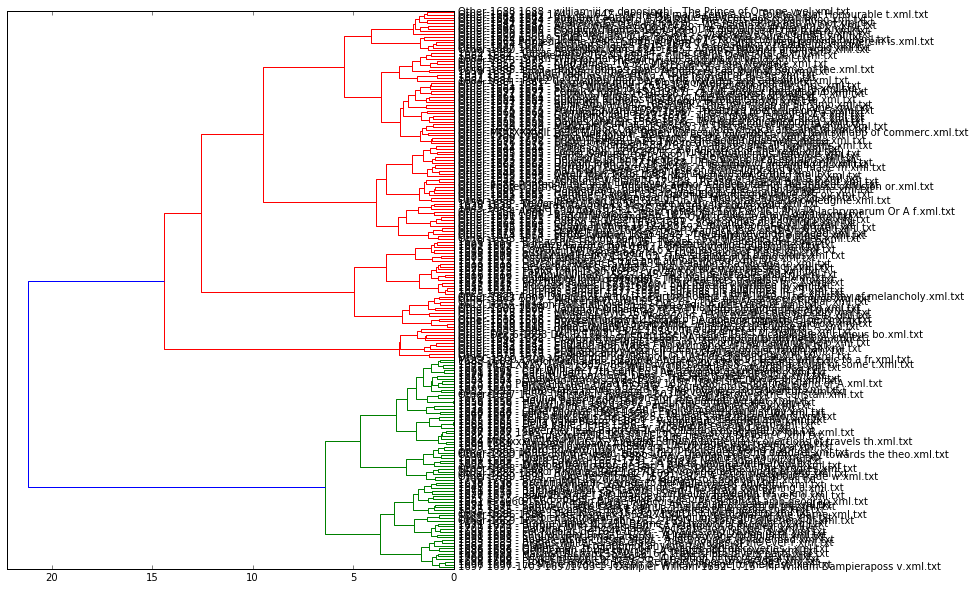

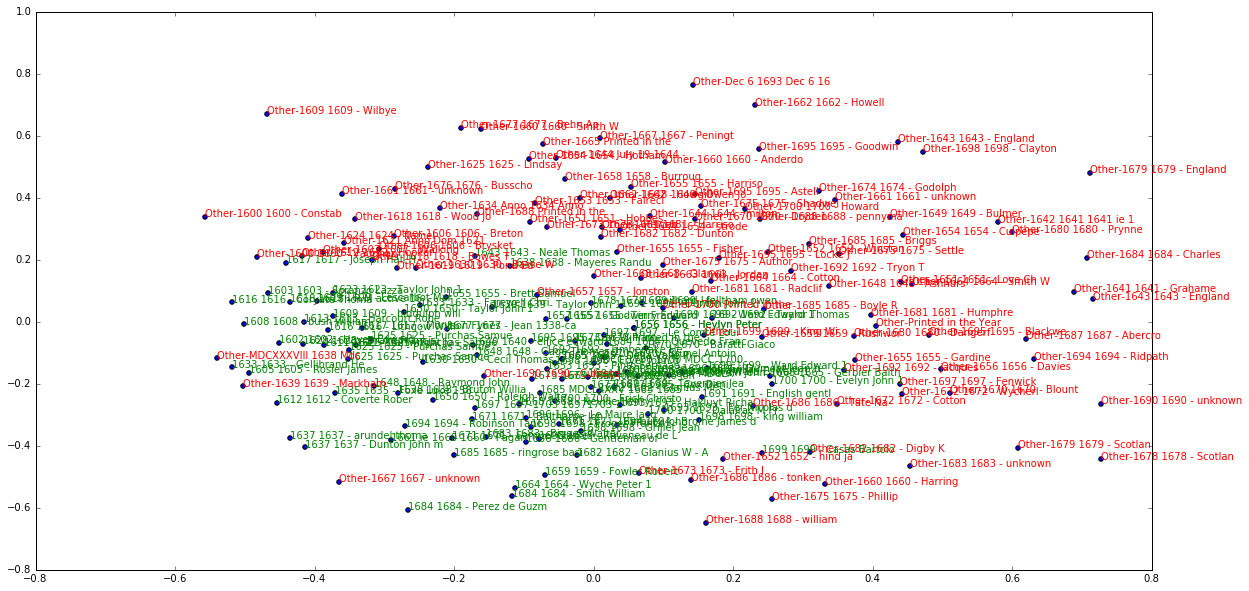

In [7]:
stoplist_vectorizer = TfidfVectorizer(use_idf=False, stop_words=nltk.corpus.stopwords.words("english"), max_features=5000)
plot_corpus_similarity(corpus, stoplist_vectorizer)

There are still a few outliers, but after reviewing them, I decided to keep them - all are quite related to travel (or at least, the style of travel as I've defined it), and I suspect that a few of them appear more unique because they were translated from another language (Perez's 1684 text, for example).

### On to classification

What do machine learning classifiers think of this corpus?

In [8]:
import random
from pandas import DataFrame
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

def benchmark_svms(labelled_texts, runs, vectorizer):
    results = defaultdict(list)
    split = int(len(labelled_texts)/2)
    for i in range(0, runs):
        random.shuffle(labelled_texts)
        train_set, test_set = labelled_texts[split:], labelled_texts[:split]
        train_set_categories = ["Other" if "Other" in category else "Travel" for category, text in train_set]
        test_set_categories = ["Other" if "Other" in category else "Travel" for category, text in test_set]
        X_train = vectorizer.fit_transform([text for category, text in train_set])
        X_test = vectorizer.transform([text for category, text in test_set])

        for clf, name in (
                (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
                (Perceptron(n_iter=50), "Perceptron"),
                (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
                (KNeighborsClassifier(n_neighbors=10), "kNN"),
                (LinearSVC(), "LinearSVC"),
                (LinearSVC(loss='l2', penalty="l2", dual=False, tol=1e-3), "LinearSCV l2"),
                (LinearSVC(loss='l2', penalty="l1", dual=False, tol=1e-3), "LinearSCV l1"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="l2"), "SGD l2"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="l1"), "SGD l1"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet"), "SGD elasticnet"),
                (NearestCentroid(), "NearestCentroid (aka Rocchio classifier"),
                (MultinomialNB(alpha=.01), "Naïve Bayes Multinomial"),
                (BernoulliNB(alpha=.01), "Naïve Bayes Bernoulli")):
            clf.fit(X_train, train_set_categories)
            pred = clf.predict(X_test)
            results[name].append(clf.score(X_test, test_set_categories))
    orderedresults = [(name, values) for name, values in results.items()] 
    results_df = DataFrame([values for name,values in orderedresults], index=[name for name,values in orderedresults])
    print("Ordered averages:")
    print(results_df.mean(axis=1).order(ascending=False))
    results_df.transpose().plot(figsize=(20, 10))

### Supervised Classification of Full Corpus

Let's run a first set of test by sending all the texts in our corpus. We need to use an ordered list of labelled texts because the order of the texts will be randomized during use and we need a way of retrieving the label.

C:\Users\broomgrass\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:299: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
C:\Users\broomgrass\Anaconda3\lib\site-packages\sklearn\svm\classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
C:\Users\broomgrass\Anaconda3\lib\site-packages\sklearn\svm\classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
C:\Users\broomgrass\Anaconda3\lib\site-packages\sklearn\svm\classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility

Ordered averages:
NearestCentroid (aka Rocchio classifier    0.947059
LinearSVC                                  0.943137
LinearSCV l2                               0.943137
Ridge Classifier                           0.941176
SGD elasticnet                             0.933333
Passive-Aggressive                         0.931373
Naïve Bayes Multinomial                    0.923529
Perceptron                                 0.921569
SGD l2                                     0.921569
LinearSCV l1                               0.913725
SGD l1                                     0.909804
kNN                                        0.725490
Naïve Bayes Bernoulli                      0.705882
dtype: float64


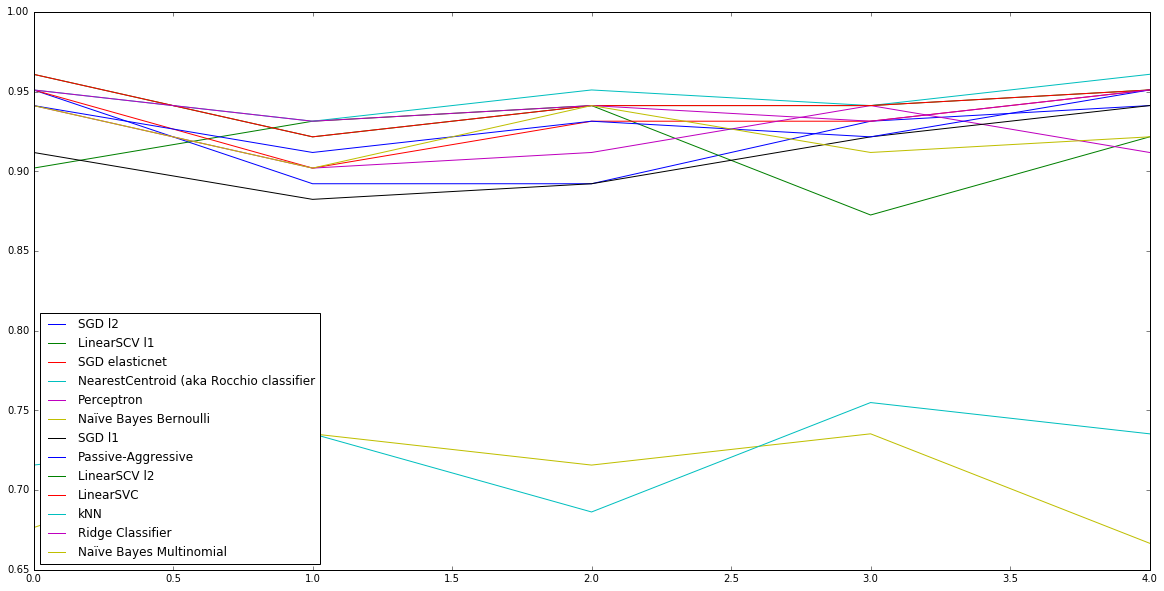

In [9]:
labelled_texts = [(fileid, corpus.raw(fileid)) for fileid in corpus.fileids()]
benchmark_svms(labelled_texts, 5, stoplist_vectorizer)

Wow! These numbers are better than what I expected, considering that my corpus is potentially more varied across 100 years instead of 50! In fact, they're better than my 1650-1700 corpus!

Scores in the .95 range are indicating that over the course of 5 runs that modeller is correctly classifying texts in our test set 95% of the time (note that every time this test is run the results may vary). Now, my hope is that I can find some texts that didn't come up in my initial searches for travel in the DREaM corpus.

The classifier created below uses the corpus for training.  We'll use the LinearSVC algorithm because it provides a way of not just classifying (travel or non-travel) but also of expressing a value for how travel...ish? or not the text is.

In [10]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# define the training corpus to use 
trav_data_dir = "C:/Users/broomgrass/iPython/Dream/data/texts"
trav_corpus = nltk.corpus.reader.plaintext.PlaintextCorpusReader(trav_data_dir+"/modcorpus", ".*\.txt")
filtered_fileids = [fileid for fileid in trav_corpus.fileids()]

# create TF-IDF (actually relative frequencies) vectorizer
stopword_vectorizer = TfidfVectorizer(use_idf=False, stop_words=nltk.corpus.stopwords.words("english"), max_features=10000)
X_train = stopword_vectorizer.fit_transform([trav_corpus.raw(fileid) for fileid in filtered_fileids])
trav_categories = ["Other" if "Other" in fileid else "Travel" for fileid in filtered_fileids]

# create a classifier
trav_clf = LinearSVC(loss='l2', penalty="l2", dual=False, tol=1e-3)
trav_clf.fit(X_train, trav_categories)

C:\Users\broomgrass\Anaconda3\lib\site-packages\sklearn\svm\classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)

#### Analyzing the HTRC Genre Corpus
The notebook I'm drawing from uses the HTRC Genre corpus, which is organized by genre (if you rsync the directory rather than just download the files from the web the files are organized into subfolders by genre). 

Here's how they do it:
For each genre there's a metadata file with all the volumes for that genre and then a set of compressed archives (.tar.gz) organized by time slice. Our strategy here will be as follows:
- for each genre folder (fiction, drama, poetery)
- read the metadata file into a table
- for each compressed archive in the genre folder (*.tar.gz)
    - for each tab-separated values file in the archive
create a pseudo text
        - for each word-count pair: add the word the specified number of times to our pseuedo text
        - produce a classifier decision (a value how philosophical the text is
add the prediction value to the corresponding row in the metadata table

##### But, what do I want to do?

I already have the texts as .txt files, and I don't have metadata beyond the date, author, and partial title as part of the filename. So the tar.gz info/code is largely irrelevant to me.

##### Questions:
- do I still need the metadata bits? Can I just say metadata = fileids?

In [29]:
from os import walk
    # note: The method walk() generates the file names in a directory tree 
    # by walking the tree either top-down or bottom-up.
import pandas as pd
from os.path import join
import glob

def get_genre_metadata_and_predictions(genre_dir, clf, vectorizer):
    metadatas = {} # curly braces mean defining a dictionary, which makes an array with names, values, etc.
    # I don't need all the metadata from the original code, though.
    # so what do I need in my dictionary? I need the filename and the prediction. 
    # That's it! That should be easy?...
    # tried these - no dice - didn't work, ugh

    # metadata = [fileid in corpus.fileids()]
    # metadata = [fileid for fileid]
    # but I obviously shouldn't be making a list here, since it isn't in the original
    # can I use glob.glob somehow?
    
    # The Sentiment Analysis has some helpful steps on making a dictionary
    # http://nbviewer.jupyter.org/github/sgsinclair/alta/blob/master/ipynb/SentimentAnalysis.ipynb
    
    for fileid in corpus.fileids():
        text = ""
        for line in corpus.readlines():
            word, count = line.decode("utf-8").strip().split("\t")
            # so is word, count making tuples?
            if any(c for c in word if c.isalpha()):
                text += (word + " ") * int(count)
                    
    # predict the class
    X_test = vectorizer.transform([text])
    metadata['prediction'] = clf.decision_function(X_test)[0]

# sure what to do about metadatas yet - look at it tomorrow morning. 
    
metadatas[genre] = metadata.sort('prediction', ascending=False)
break
return metadatas

NameError: name 'metadata' is not defined

In [13]:
trav_dir = "C:/Users/broomgrass/iPython/HathiTrust/data"
trav_metadatas = get_genre_metadata_and_predictions(htrc_genre_dir, trav_clf, stopword_vectorizer)

In [15]:
type(corpus)

nltk.corpus.reader.plaintext.PlaintextCorpusReader

Hmm. At this point, I'm not sure how to progress. The [Classifying HTRC Genre Word Frequencies notebook](https://github.com/htrc/ACS-TT/blob/ae27740fdc4834ee8bdc84e358e7883c9173266f/tools/notebooks/ClassifyingHtrcGenreWordFrequencies.ipynb) has some interesting chunks of code that would do some interesting things, but I'm not sure how to extricate what I want to work with my corpus - my files, structure, and metadata are different than that of the HTRC corpus. 

At this point, it might be helpful for me to stop and think about what I want to do with this corpus. I want to think about this both as practice/training for my 18th century corpus, but I recognize that asking the same types of questions won't necessarily work.

### Thoughts
- I'm not particularly interested in seeing patterns by genre, as happens in the HTRC notebook. In part, that's because the task would be incredibly difficult, since I don't have that depth of metadata.
- 